In [ ]:
%pip install numpy, matplotlib, opencv-python, jupyterlab

from IPython.core.display import HTML
import pathlib
styles_path = pathlib.Path(pathlib.Path().absolute(), "style", "style.css")
styles = open(styles_path, "r").read()
HTML(f"<style>{styles}</style>")

# 1.0 Image Processing I

### Contents

1.1 Linear Filtering \
1.1.1 [Probability Density](#111-probability-density-gaussian-noise) \
1.1.2 [Convolution vs Correlation](#convolution) \
1.1.3 [Shift Invariant Linear System](#113-shift-invariant-linear-system)

1.2 Nonlinear Filtering


$\large{\text{1.1 Linear Filtering}} \\ \large{\text{1.1.1 Probability Density (Gaussian Noise)}} $

---

This section uses the Probability Density Function of the Normal Distribution (also known as the Gaussian distribution). The Normal Distribution is a bell-shaped curve, with a mean, and a standard deviation(the measure of how far the values are spread out from the mean). The standard deviation is the square root of the variance.

Probability Density Function was first derived by De Moivre, and 200 years later by both Gauss and Laplace independently. The Normal Distribution occurs often in nature. For example, it describes the commonly occurring distribution of samples influenced by a large number of tiny, random disturbances, each with its own unique distribution

The Probability Density Function for the Gaussian Distribution is:

$ f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}} $

where 
$\mu$ is the mean
$\sigma$ is the standard deviation. 
The square of the standard deviation, $\sigma^2$, is called the variance.



The equation for Probability Density Function of a Gaussian distribution is:

$ f(x,y) = \overbrace{\widehat{f}(x,y)}^{\text{Ideal Image}} + \overbrace{\eta(x,y)}^{\text{Noise Process}} $

In the equation, the observed pixel intensity $f$ at position (x,y) is composed of the ideal image content $\widehat{f}$ at position (x,y) plus an editive noise term. The editive noise term $\eta(x,y)$ is a random variable that is normally distributed with mean zero and variance $\sigma^2$.

Below logic demonstrates Probability Density Function and visualizes the results. We take an horizontal slice through one row of the original image and plot the intensities along the slice, and repeat the same process for the edited image. When the curves are compared, it is observed that pixel intensities vary around the true value.

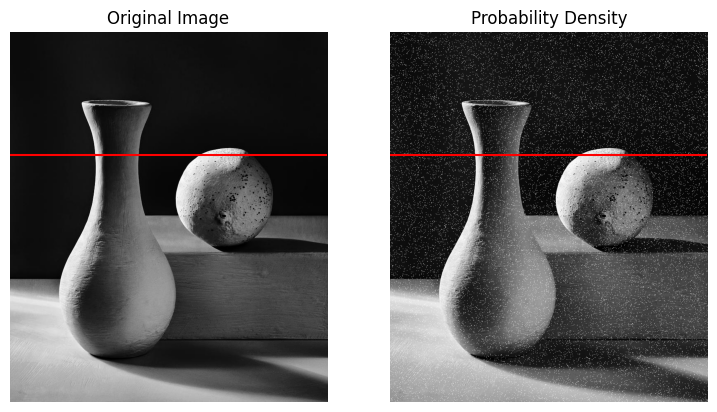

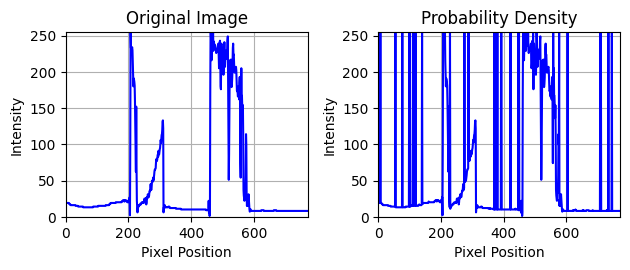

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original image
image_path = 'img/gaussian_original.jpg'
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if original_image is None:
    print(f"Failed to load image from path: {image_path}")
else:
    # Display the original image and noisy image side by side
    plt.figure(figsize=(9, 6))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')
    plt.axhline(original_image.shape[0] // 3, color='r', linestyle='-')
    plt.axis('off')

    # Gaussian noise parameters
    mean = 0
    variance = 0.3  # varience controls the amount of noise
    sigma = variance ** 0.5
    gaussian_noise = np.random.normal(mean, sigma, original_image.shape)
    gaussian_noise = gaussian_noise.reshape(original_image.shape).astype('uint8')

    # Adding Gaussian noise to the original image
    noisy_image = cv2.add(original_image, gaussian_noise)

    # Plot the noisy image
    plt.subplot(1, 2, 2)
    plt.imshow(noisy_image, cmap='gray')
    plt.title('Probability Density')
    plt.axhline(original_image.shape[0] // 3, color='r', linestyle='-')
    plt.axis('off')

    plt.show()

    # Original Image
    # Selecting a row (slice) for the horizontal section plot
    row_index_original = original_image.shape[0] // 3  # Row
    intensities_original = original_image[row_index_original, :]

    # Plotting the horizontal section (pixel intensities along the selected row)
    plt.subplot(2, 2, 3)
    plt.plot(intensities_original, color='b')
    plt.title('Original Image')
    plt.xlabel('Pixel Position')
    plt.ylabel('Intensity')
    plt.xlim(0, len(intensities_original))
    plt.ylim(0, 255)  # ylim is adjusted based on intensity range (0-255 for grayscale)
    plt.grid(True)



    # Probability Density Image
    # Selecting a row (slice) for the horizontal section plot
    row_index_noisy = noisy_image.shape[0] // 3  # Row
    intensities_noisy = noisy_image[row_index_noisy, :]

    # Plotting the horizontal section (pixel intensities along the selected row)
    plt.subplot(2, 2, 4)
    plt.plot(intensities_noisy, color='b')
    plt.title('Probability Density')
    plt.xlabel('Pixel Position')
    plt.ylabel('Intensity')
    plt.xlim(0, len(intensities_noisy))
    plt.ylim(0, 255)  # ylim is adjusted based on intensity range (0-255 for grayscale)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


### Moving Average in 2D

Figure-1 shows target image $F$ and its only two pixel values of 0 and 90, where zero denotes black pixels, and 90 denotes the white ones. As seen in the red box filter kernel, one pixel is targeted and eight surrounding pixels in its neighborhood are taken, and we simply average their values. The resulting of the averaging operation is then written into the result image $G$. This operation is then repeated for all pixels in the target image.

As seen on Figure-4, the isolated noise pixels are smoothed out. This shows the effectiveness of this process for smoothing out certain kinds of noise. In the same figure, it can be seen that the hard borders in $F$ is also softened in $G$.

It should be noted that, we only took into account the pixels that were fully inside the box filter kernel, and therefore in this operation we do not have values for boundary pixels in the result image $G$. In order to get the values for the pixels in the border region, the average box filter would need to extend partially outside the image.

![](img/movingaverage2d.png){width=80%}

### References for Section 1.1.1

---

[1] P. R. Peebles Jr., “Central Limit Theorem” in “Probability, Random Variables and Random Signal Principles”, 4th ed., 2001, pp. 51, 51, 125.

[2] Wikipedia, “Normal distribution”, https://en.wikipedia.org/wiki/Normal_distribution



&nbsp;
&nbsp;


<a id="convolution"></a>

### 1.1.2 Convolution vs Correlation

The correlation of two signals  $f(t)$ and $ g(t) $ is defined as:

$(f \star g)(\tau) = \int_{-\infty}^{\infty} f(t) g(t+\tau) \, dt$

$(f \star g)(\tau) = \sum_{t=-\infty}^{\infty} f(t) g(t+\tau) $



The convolution of two signals $ f(t) $ and $ g(t) $ is defined as:

$ (f * g)(t) = \int_{-\infty}^{\infty} f(\tau) g(t-\tau) \, d\tau $

$ (f * g)(t) = \sum_{\tau=-\infty}^{\infty} f(\tau) g(t-\tau) $



&nbsp;
&nbsp;

### 1.1.3 Shift Invariant Linear System

In these systems, the operator behaves the same throughout the system. For example, the value of the output depends on the pattern in the image neighborhood, not the position of the neighborhood.

Shift Invariant is the property of a function that does not change its output when the input is shifted.

The system is considered linear if it fulfills the conditions of superposition and scaling:

- Superposition: $h*(f_1+f_2)=(h*f_1)+(h*f_1)$ \
- Scaling: $h*(kf)=k(h*f)$

&nbsp;

Properties that Convolution fulfills:
- Linear and Shift Invariant
- Commutative $f*g=g*f$
- Associative $(f*g)*h=f*(g*h)$
    - Often applies several filters in a sequence $(((a*b_1)*b_2)*b_3)$
    - This is equivalent to applying one filter: $a*(b_1*b_2*b_3)$
- Identity: $f*1=f$
    - for unit impulse $e=[...,0,0,1,0,0,...]$
- Differentiation: $\frac{\partial{}}{\partial{x}}(f*g)=\frac{\partial{f}}{\partial{x}}*g$
